In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DatabaseDF = pd.read_csv("../CleanedDataset.csv")

## Definition

The edgewroth box diagram is a tool used in economics that plots the indifference curves of two groups so that an efficient trade between the two can be found.

An indifference curve is a plot in economics where given an x axis of the quantity of a certain good, and a y axis of a quantity of a different good, curve is drawn connecting all points of (x,y) pairs (meaning they have x of one good and y of the other) that have the same utility. Since a certain good may provide more utility than another this line is not always 1:1, and since there could be a margin of decreasing return (the more you get of one quantity the benefit from earning one more may decrease) meaning this line may be curved. It is called an indifference curve since by definition the user does not care which pair of coordinates on the line it has since they all provide the same utility.

By plotting two indifference curves with origns on opposite corners, an edgworth box is able to determine where they cross at a point called the Pareto Optimality. At this point the two parties have exchanged their resources in such a way that they both purely benefited from the trade. 

Our goal is to determine if there is a relationship between two variables that fits this idea of indifference curves for wells, and if there would ever be a situation where an exchange between wells could occurr how an edgworth box might facilitate that.

## Creating oil well indifference curves

My First hypothesis is that stage completion type and quantity may follow this model of indifference curves, where perhaps buidling more of one type than another could change how much oil is generated. Firstly I want to determine if there is a link between number of stages and oil production, and idealy this should show that more stages always means more oil

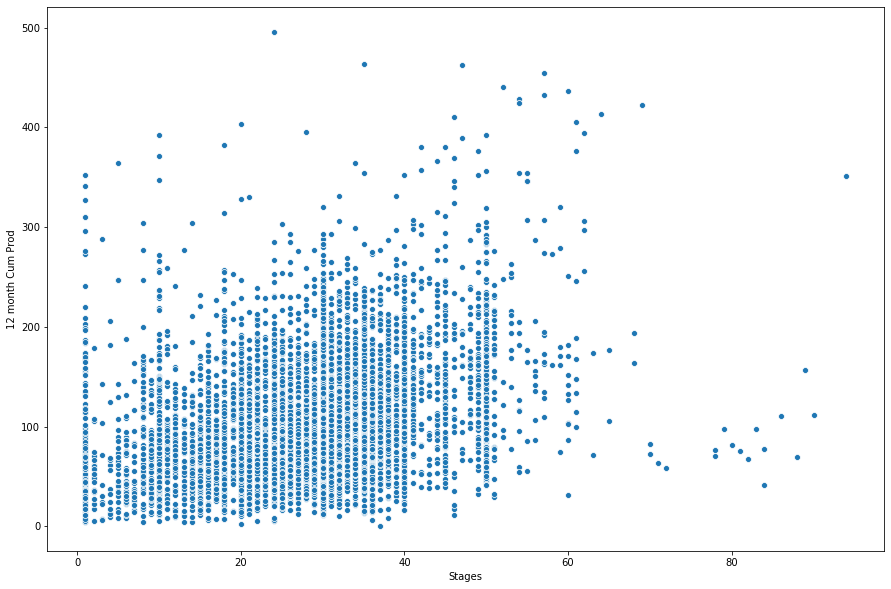

In [3]:
plt.subplots(figsize = (15,10))
sns.scatterplot(x = 'Stages', y = '12 month Cum Prod', data = DatabaseDF)

Whith the exception of some outlier points at the end of the list this seems to show that more stages increases oil production, however it appears to be an exponential curve at the very least with there being a greater increase as the stages increase. I will firstly chop off the outliers above 70 stages in order to look at just the exponential data

In [4]:
DatabaseDF = DatabaseDF[DatabaseDF['Stages'] < 70]

In [5]:
def plotfunc(x, a, b, c):
    return a * (b**x) + c

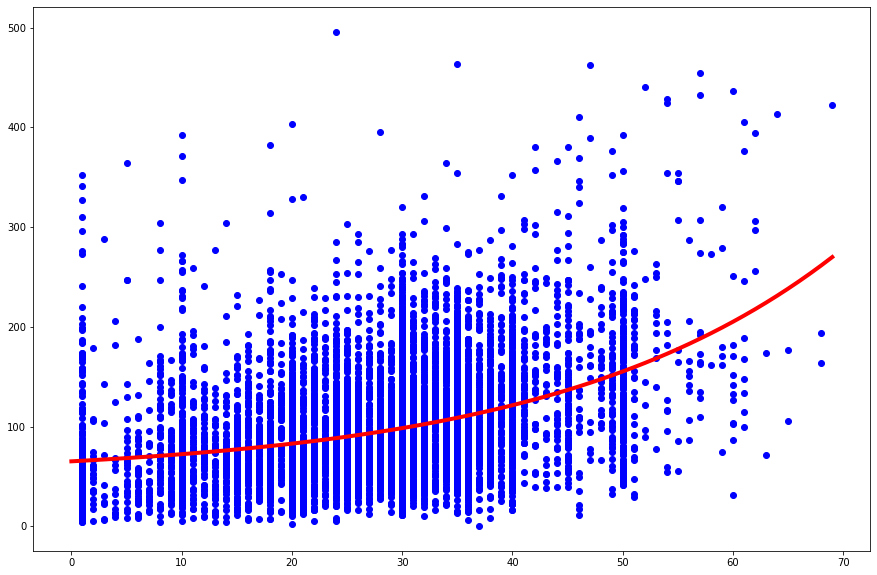

In [6]:
from scipy.optimize import curve_fit

x = DatabaseDF['Stages']
y = DatabaseDF['12 month Cum Prod']

plt.subplots(figsize = (15,10))
plt.plot(x,y, 'bo')

popt, pcov = curve_fit(plotfunc,x,y)

x_plot = np.linspace(0, x.max(), x.max() + 1)

plt.plot(x_plot,plotfunc(x_plot, popt[0], popt[1], popt[2]), 'r-',
            linewidth = 4)

plt.show()

**TODO:** Determine the error behind using a model like this 

Now that this has been plotted for stages as a whole and we generally can see that the curve follows the correct trends, I will try to do the same for two types of stages in particular, Sleeves and P&P

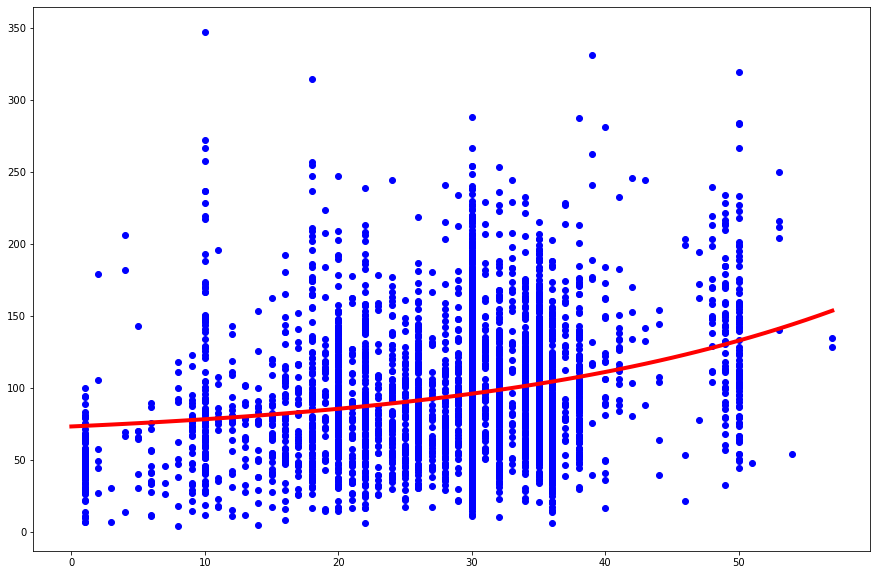

In [7]:
x_sleeves = DatabaseDF[DatabaseDF['Completion Type'] == 'Sleeves' ]['Stages']
y_sleeves = DatabaseDF[DatabaseDF['Completion Type'] == 'Sleeves' ]['12 month Cum Prod']

plt.subplots(figsize = (15,10))
plt.plot(x_sleeves,y_sleeves, 'bo')

popt_sleeves, pcov_sleeves = curve_fit(plotfunc,x_sleeves,y_sleeves)

x_plot_sleeves = np.linspace(0, x_sleeves.max(), x_sleeves.max() + 1)

plt.plot(x_plot_sleeves,plotfunc(x_plot_sleeves, popt_sleeves[0], popt_sleeves[1], popt_sleeves[2]), 'r-',
            linewidth = 4)

plt.show()

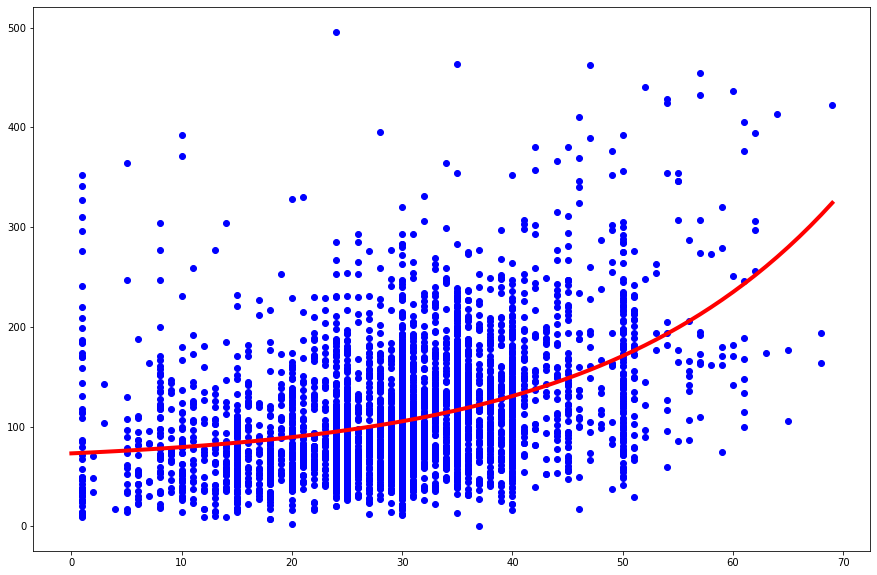

In [8]:
x_PandP = DatabaseDF[DatabaseDF['Completion Type'] == 'P & P' ]['Stages']
y_PandP = DatabaseDF[DatabaseDF['Completion Type'] == 'P & P' ]['12 month Cum Prod']

plt.subplots(figsize = (15,10))
plt.plot(x_PandP,y_PandP, 'bo')

popt_PandP, pcov_PandP = curve_fit(plotfunc,x_PandP,y_PandP)

x_plot_PandP = np.linspace(0, x_PandP.max(), x_PandP.max() + 1)

plt.plot(x_plot_PandP,plotfunc(x_plot_PandP, popt_PandP[0], popt_PandP[1], popt_PandP[2]), 'r-',
            linewidth = 4)

plt.show()

In order to to see if this is an accurate way of measuring oil production, I will now compare how our predictions stack up with the available data of oil wells that mix Sleeves and P&P completions. The only issue however is in how we will deal with the constant C used in both equations. The constant is supposed to account for the base production that drilling at all should yield, with 0 stages. simply doing predict(sleeve) + predict(p&p) = predict(combined) will not work since it takes int account both constants. I will try out a couple options below to see which is closest in predicting the right values

In [9]:
mixedDF = DatabaseDF[DatabaseDF['Completion Type'] == 'Sleeves and P & P'].fillna(0)

mixedDF = mixedDF[['Stages', 'Sleeves', 'P&P', '12 month Cum Prod']]

def estimateNaive(sleeves, pandp):
    pandpEst = plotfunc(pandp, popt_PandP[0], popt_PandP[1], popt_PandP[2])
    sleeveEst = plotfunc(sleeves, popt_sleeves[0], popt_sleeves[1], popt_sleeves[2])

    return pandpEst + sleeveEst

def estimateNoConst(sleeves, pandp):
    pandpEst = plotfunc(pandp, popt_PandP[0], popt_PandP[1], 0)
    sleeveEst = plotfunc(sleeves, popt_sleeves[0], popt_sleeves[1], 0)

    return pandpEst + sleeveEst

def estimateMixed(sleeves, pandp):
    total = sleeves + pandp
    pandpEst = plotfunc(pandp, popt_PandP[0], popt_PandP[1], popt_PandP[2] * (pandp/total))
    sleeveEst = plotfunc(sleeves, popt_sleeves[0], popt_sleeves[1], popt_sleeves[2] * (sleeves/total))

    return pandpEst + sleeveEst

In [10]:
naiveError = 0
NCError = 0
MXError = 0

counter = 0;

for index, row in mixedDF.iterrows():
    counter += 1;
    
    Actual = row['12 month Cum Prod']
    Naive = estimateNaive(row['Sleeves'], row['P&P'])
    NC = estimateNoConst(row['Sleeves'], row['P&P'])
    MX = estimateMixed(row['Sleeves'], row['P&P'])

    naiveError += abs(Actual - Naive)
    NCError += abs(Actual - NC)
    MXError = abs(Actual - MX)

print("Total Checked: ", counter)
print("Naive Error: ", naiveError)
print("No Constant Error: ", NCError)
print("Mixed Error: ", MXError)

Total Checked:  360
Naive Error:  25552.9423395637
No Constant Error:  21999.942017188132
Mixed Error:  41.601204202064366


By far and away the most accurate form of prediction was the estimateMixed formula which took into account the percentage of stages that were of the corresponding type. It also way outperformed even our initial expecxtations, showing that perhaps this is a relatively accurate way of predicting oil production

In order to create the indifference curves, I will use a contour plot to showcase how increasing Sleeve and P&P completions affects total oil production 

In [11]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

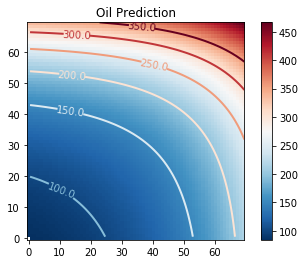

In [12]:
sleeves_grid = np.arange(0, 70, 1)
pandp_grid = np.arange(0,70,1)

Sleeves, PandP = meshgrid(sleeves_grid,pandp_grid)
oilProduction = estimateMixed(Sleeves,PandP)

im = imshow(oilProduction, cmap = cm.RdBu_r, origin = 'lower')

title('Oil Prediction')

cset = contour(oilProduction, np.arange(0,400,50), linewidths = 2, cmap=cm.RdBu_r, origin = 'lower')
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)

colorbar(im)

show()

These are our indifference curves, any point along those contours has the same prediction of oil production based on the x axis of sleeves and y axis of p&p completions. With these in hand we should be able to create a boxworth diagram that attempts to solve for an optimal exchange between wells

## Implementing the Boxworth Diagram

The main issue with using an edgeworth box is that it attempts to figure out the optimal exchange for two groups who trade a limited resource, in such a way that they both maintain their same level of utility. While this isn't exactly how oil production works I think it would be interesting to see how given two existing wells and theri already established distribution of completion types, they could perhaps be exchanged such that they both benefit

In [13]:
import pyEdgeworthBox as eb

In [14]:
EB = eb.EdgeBox( u1 = estimateMixed, u2 = estimateMixed,
                IE1 = [20,20], IE2 = [40,40])

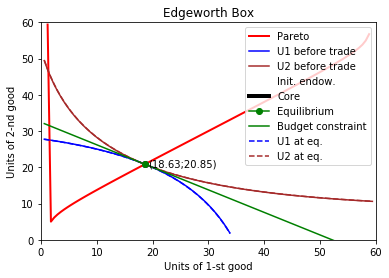

In [15]:
EB.plot()

While this package is useful I think it is too barebones as a good edgeworth box diagram, and would like to create one myself

first challenge comes in trying to determine the best way to create two indifference curves drawn on the same graph. The previous indifference curves were done using the contour feature, however I think in order to create a model whre I can check overlaping points I will need to determine a function to calulcate y from x on a graph, or in other words given a number of sleeves and 12 month cum prod calculate how many p&p sleeves would be requred to achieve that.

In [16]:
import math

In [17]:
testfunc = lambda x,z: (math.log(-(plotfunc(x, popt_sleeves[0], popt_sleeves[1], popt_sleeves[2]) - z)/(popt_PandP[0]))) / (math.log(popt_PandP[1]))

for x in range(1,100):
    for y in range(1,100):
        z = estimateMixed(x,y)

        if (math.floor(testfunc(x,z)) != y):
            print("x-",x)
            print("error: y-",y,"|func-",testfunc(x,z) )

x- 1
error: y- 4 |func- 5.006455356642956
x- 1
error: y- 5 |func- 6.000955511092161


In [18]:
z = estimateMixed(32,0)
print(z)

109.14152568309517


In [19]:
for x in range(0,33):
    y = testfunc(x,z)
    print("x: ", x, " | y: ", y)
    print("z: ", estimateMixed(x,y))

x:  0  | y:  26.254158171453653
z:  109.90714298483577
x:  1  | y:  25.99884828216763
z:  109.87878557885537
x:  2  | y:  25.730766341496523
z:  109.85192508769495
x:  3  | y:  25.449101157020174
z:  109.82640750245464
x:  4  | y:  25.152971758709292
z:  109.80209471626442
x:  5  | y:  24.84141930990634
z:  109.77886200500208
x:  6  | y:  24.513397809190437
z:  109.75659587634365
x:  7  | y:  24.167763359369218
z:  109.73519220831099
x:  8  | y:  23.803261729989508
z:  109.71455461242525
x:  9  | y:  23.418513876796155
z:  109.69459296660077
x:  10  | y:  23.011999001483282
z:  109.67522206974482
x:  11  | y:  22.58203463245053
z:  109.656360374094
x:  12  | y:  22.126753074696904
z:  109.63792875279977
x:  13  | y:  21.644073404251415
z:  109.61984925910991
x:  14  | y:  21.131667955431382
z:  109.60204382933976
x:  15  | y:  20.586921947688946
z:  109.58443287399814
x:  16  | y:  20.00688449424091
z:  109.56693368875496
x:  17  | y:  19.388208685694334
z:  109.54945859751095
x:  18  

While I am not thrilled about the results of this as there seems to be some error still, I think it should suffice to move on and at least create a proof of concept

In [20]:
PandPCalc = testfunc

(0, 60)

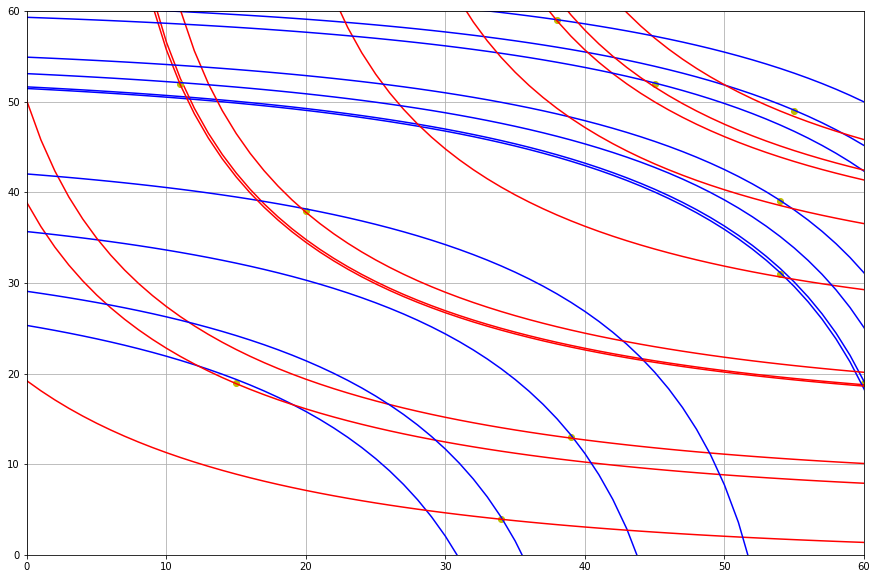

In [21]:
from random import randint

plt.subplots(figsize = (15,10))

totalSleeves = 60
totalPandP = 60

initialList = []

for i in range(1,12):
    initialList.append([randint(1,60),randint(1,60)])

##initialList = [[20,20],[40,40],[15,30],[24,12]]

for x_Initial in initialList:

    y_Initial = [totalSleeves - x_Initial[0], totalPandP - x_Initial[1]]

    ## person X

    plt.plot(x_Initial[0],x_Initial[1], 'yo')

    x_z = estimateMixed(x_Initial[0], x_Initial[1])

    x_cords = []
    x_res = []

    done = False
    x_counter = 0

    while not done:
        x_current_res = PandPCalc(x_counter, x_z)

        if (x_current_res < 0):
            done = True

        x_cords.append(x_counter)
        x_res.append(x_current_res)

        x_counter += 1

    plt.plot(x_cords, x_res, 'b-')

    ## person Y

    y_z = estimateMixed(y_Initial[0], y_Initial[1])

    y_cords = []
    y_res = []

    done = False
    y_counter = 0

    while not done:
        y_current_res = PandPCalc(y_counter,y_z)

        if(y_current_res < 0):
            done = True

        y_cords.append(totalSleeves - y_counter)
        y_res.append(totalPandP - y_current_res)

        y_counter += 1

    plt.plot(y_cords, y_res, 'r-')



plt.grid()

plt.xlim(0,totalSleeves)
plt.ylim(0,totalPandP)

After completing this I have come to realize something, since we have two variables where there is an exponential increase in utility output It is actually optimal to fully specialize into only one completion type rather than mixing stages. I will test this hypothesis to be sure. However that does not meant this is entirely useless, there are a lot of details that go into completion types chosen and perhaps there could be only a finite ammount of states that you can choose from, in which case it would be handy to know if there is an optimal one

## Extra testing: specializing in one completion type yields optimal results

In [22]:
DatabaseDF = pd.read_csv("../CleanedDataset.csv")

In [23]:
counter = 0

hits = 0

for index, row in mixedDF.iterrows():
    prod =  row['12 month Cum Prod']

    sleeveDF = DatabaseDF[(DatabaseDF['Completion Type'] == 'Sleeves') & (DatabaseDF['Stages'] == row['Stages'])]
    pandpDF = DatabaseDF[(DatabaseDF['Completion Type'] == 'P & P') & (DatabaseDF['Stages'] == row['Stages'])]

    if (len(sleeveDF) > 0 and prod > sleeveDF['12 month Cum Prod'].mean()):
        hits += 1
    elif (len(pandpDF) > 0 and prod > pandpDF['12 month Cum Prod'].mean()):
        hits += 1

    if (len(sleeveDF) > 0 or len(pandpDF) > 0):
        counter += 1

print("Hit Percent: " , (hits/counter))

Hit Percent:  0.44722222222222224


This tells us that about 44.7% of the time not specializing actually yielded higher results, however I think it's telling that the majority of the time specalizaiton was the correct choice. Perhaps we should analyze why those 44.7% hit and what made them so